# GWU Datathon - Jesse Borg

## Introduction

This report was done for the GWU Datathon between April 2, 2021 and April 4, 2021. The report will look at crash data from the Metropolitan Police Department (MPD) and will include data preprocessing, exploratory data analysis hyperparameter/model selection and an interpertaion of the findings. Suggestions on current policies will also be included based on the findings.

## Abstract

According to the CDC, "road traffic crashes are a leading cause of death in the United States for people aged 1–54, and they are the leading cause of nonnatural death for U.S. citizens residing or traveling abroad. It is estimated that fatal and nonfatal crash injuries will cost the world economy approximately $1.8 trillion dollars. This article can be accessed at: https://www.cdc.gov/injury/features/global-road-safety/index.html#:~:text=Road%20traffic%20crashes%20are%20a,citizens%20residing%20or%20traveling%20abroad.

Reports from the National Highway Traffic Safety Administration (NHTSA) focusing on motor-vehicle traffic fatalities in 2019 and the first half of 2020 suggest that overall, roads were safer in 2019 than 2018, continuing a three-year trend that started in 2017. However, based on the agency's early estimates U.S. roads were more dangerous in the second quarter of 2020 than they have been in years.

This study aims to get a deeper understanding on traffic crashes in Washington DC and which factors have the greatest effect on whether a collision will be fatal or not. To do this, an extensive EDA was carried on data derived from the Metropolitan Police Department's (MPD) crash data. After the EDA was done, different models were implemented to find the feautures with the most importance when determining whether a collision will be fatal or not. These results were be cross-referenced with the insights from the EDA to make sure they make sense. 

A number of key findings were obtained from the results:
 - The type of person involved in any type of collision is very likely to be the driver
 - People between the ages of 18-29 are most likely to be involved in a collision
 - Passenger Cars/Automobiles are the type of vehicle mostly involved in a collision
 - 0.072% of all crashes were fatal, 2% resulted in a major injury and 12.3% resulted in a minor injury
 - Just 1.96% of the drivers involved in a fatal collision were deemed impaired
 - 14.7% of vehicles involved in fatal collisions were deemed to be speeding
 - Unplated vehicles are involved in fatal collisions proportionally much higher than non-fatal collisions
 - The final selected models were the XGB Classifier and the Decision Tree classifier with a score of 0.999297 and 0.988137 respectively
 - The most important features from the combined models when predicting whether a collision will be fatal are; if the person involved is a pedestrian or motorcyclist, or if they were speeding.

## Pipeline

This section will implement the full pipeline of the project, which includes data preprocessing, exploratory data analysis, hyperparameter tuning/model selection and interpretation.

### Data Preprocessing

In [1]:
# Start by loading the required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# Load Dataset
crash_data = pd.read_csv('Crash_Details_Table.csv', header = 0)

# Display first few rows to ensure data has been loaded correctly
crash_data.head()

C:\Users\12023\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,OBJECTID,CRIMEID,CCN,PERSONID,PERSONTYPE,AGE,FATAL,MAJORINJURY,MINORINJURY,VEHICLEID,INVEHICLETYPE,TICKETISSUED,LICENSEPLATESTATE,IMPAIRED,SPEEDING
0,438194351,26872544,16034312,84628234,Passenger,31.0,N,N,N,2275009,Passenger Car/automobile,N,VA,Y,N
1,438194352,26872544,16034312,84833902,Passenger,31.0,N,N,N,2275009,Passenger Car/automobile,N,VA,Y,N
2,438194353,26872544,16034312,84938064,Driver,NaN,N,N,N,2275007,Passenger Car/automobile,N,None,N,N
3,438194354,26872544,16034312,84790164,Driver,31.0,N,N,N,2275009,Passenger Car/automobile,N,VA,N,N
4,438194355,26872544,16034312,84953497,Passenger,47.0,N,N,Y,2275008,Passenger Car/automobile,N,VA,Y,N


In [3]:
# Get an idea of the size of the dataset
print('Number of Rows: ', crash_data.shape[0])
print('Number of Columns: ', crash_data.shape[1])

Number of Rows:  596381
Number of Columns:  15


In [4]:
# Column (2) has mixed data types - further investigation
print(crash_data.dtypes)

OBJECTID               int64
CRIMEID                int64
CCN                   object
PERSONID               int64
PERSONTYPE            object
AGE                  float64
FATAL                 object
MAJORINJURY           object
MINORINJURY           object
VEHICLEID             object
INVEHICLETYPE         object
TICKETISSUED          object
LICENSEPLATESTATE     object
IMPAIRED              object
SPEEDING              object
dtype: object


In [5]:
# Set Data type
# crash_data = crash_data.astype({'CCN': int}) # It appears as there is an underscore before one of the values

#Remove underscore for whole column as a precaution
crash_data['CCN'] = crash_data['CCN'].str.replace('_', '')
# crash_data = crash_data.astype({'CCN': int}) # Does not work due to Nans

# Since dataframe has Nans and cannot convert to int, see which columns have Nans
crash_data.isnull().sum(axis = 0)

# Because for the CCN column, 530,845 / 596,381 (which is 89%) are Nans, I decided to remove the column
# as it has too much missing data and the information itself is not important in gaining important insights
crash_data = crash_data.drop('CCN', 1)

# For age, there is a total of 169,637 / 596,381 (which is 28% of the data) Nans, I decided to remove the rows
# which have age as nan because it still leave over 400,000 rows of data and age is an important statistic
crash_data = crash_data[crash_data['AGE'].notna()]

In [6]:
# Display updated dataframe
crash_data.head()

,OBJECTID,CRIMEID,PERSONID,PERSONTYPE,AGE,FATAL,MAJORINJURY,MINORINJURY,VEHICLEID,INVEHICLETYPE,TICKETISSUED,LICENSEPLATESTATE,IMPAIRED,SPEEDING
0,438194351,26872544,84628234,Passenger,31.0,N,N,N,2275009,Passenger Car/automobile,N,VA,Y,N
1,438194352,26872544,84833902,Passenger,31.0,N,N,N,2275009,Passenger Car/automobile,N,VA,Y,N
3,438194354,26872544,84790164,Driver,31.0,N,N,N,2275009,Passenger Car/automobile,N,VA,N,N
4,438194355,26872544,84953497,Passenger,47.0,N,N,Y,2275008,Passenger Car/automobile,N,VA,Y,N
5,438194356,26872544,85038077,Driver,63.0,N,N,N,2275008,Passenger Car/automobile,N,VA,N,N


In [7]:
# Check for null values in updated dataframe
crash_data.isnull().sum(axis = 0)

OBJECTID             0
CRIMEID              0
PERSONID             0
PERSONTYPE           0
AGE                  0
FATAL                0
MAJORINJURY          0
MINORINJURY          0
VEHICLEID            0
INVEHICLETYPE        0
TICKETISSUED         0
LICENSEPLATESTATE    0
IMPAIRED             0
SPEEDING             0
dtype: int64

### EDA

Now that the data has been pre-processed, it is ready for some EDA to get an idea of the nature of the data.

In [8]:
crash_data_fatal = crash_data.loc[crash_data['FATAL'] == 'Y']
crash_data_non_fatal = crash_data.loc[crash_data['FATAL'] == 'N']

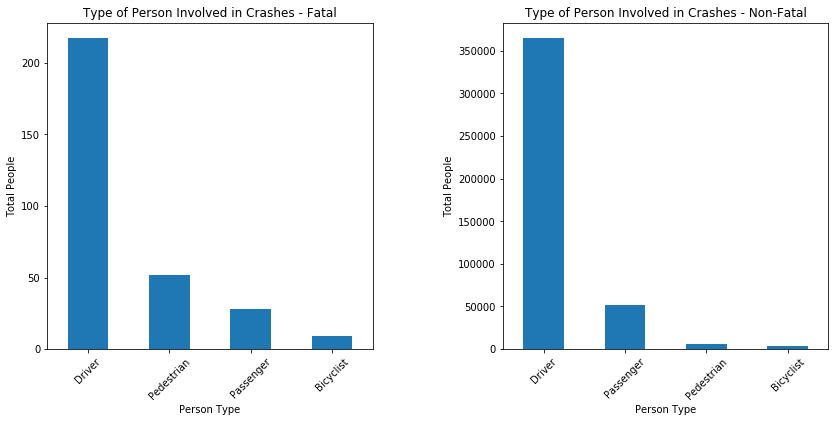

In [12]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
crash_data_fatal['PERSONTYPE'].value_counts().plot(kind='bar')
plt.xlabel('Person Type')
plt.ylabel('Total People')
plt.title('Type of Person Involved in Crashes - Fatal')
plt.xticks(rotation = 45)

plt.subplot(1,2,2)
crash_data_non_fatal['PERSONTYPE'].value_counts().plot(kind='bar')
plt.xlabel('Person Type')
plt.ylabel('Total People')
plt.title('Type of Person Involved in Crashes - Non-Fatal')
plt.xticks(rotation = 45)

plt.subplots_adjust(wspace=0.4)
plt.show()

The graph above shows that the driver is the type of person which is overwhelmingly involved in crashes. However, when it comes to fatal crashes, there is a higher percentage of pedestrians, passengers and cyclists involved. This difference is most noteable in the proportion of pedestrian involved in fatal crashes, which makes sense as pedestrians are very unprotected and if they are hit my a moving vehicle they are more likely to die.

C:\Users\12023\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\12023\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


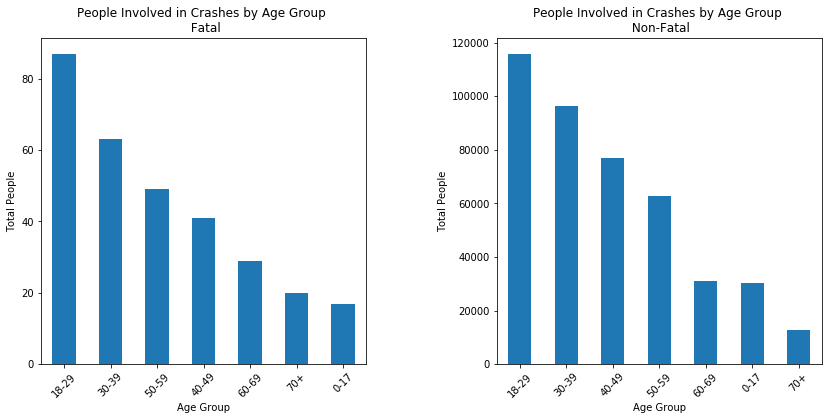

In [14]:
# Sort ages in age groups
bins = [0, 18, 30, 40, 50, 60, 70, 120]
labels = ['0-17', '18-29', '30-39', '40-49', '50-59', '60-69', '70+']
crash_data_fatal['AGE GROUP'] = pd.cut(crash_data_fatal.AGE, bins, labels = labels, include_lowest = True)
crash_data_non_fatal['AGE GROUP'] = pd.cut(crash_data_non_fatal.AGE, bins, labels = labels, include_lowest = True)


plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
crash_data_fatal['AGE GROUP'].value_counts().plot(kind='bar')
plt.xlabel('Age Group')
plt.ylabel('Total People')
plt.title('People Involved in Crashes by Age Group \n Fatal')
plt.xticks(rotation = 45)

plt.subplot(1,2,2)
crash_data_non_fatal['AGE GROUP'].value_counts().plot(kind='bar')
plt.xlabel('Age Group')
plt.ylabel('Total People')
plt.title('People Involved in Crashes by Age Group \n Non-Fatal')
plt.xticks(rotation = 45)

plt.subplots_adjust(wspace=0.4)
plt.show()

The graph above shows that those in the ages between 18 and 29 are involved in the most crashes, and those who are 70+ are involved in the fewest crashes. The pattern is almost the same for fatal vs non fatal crashes, with the main differences being that 50-59 year olds are more likely to be involved in fatal crashes when, along with 70+ year olds. 

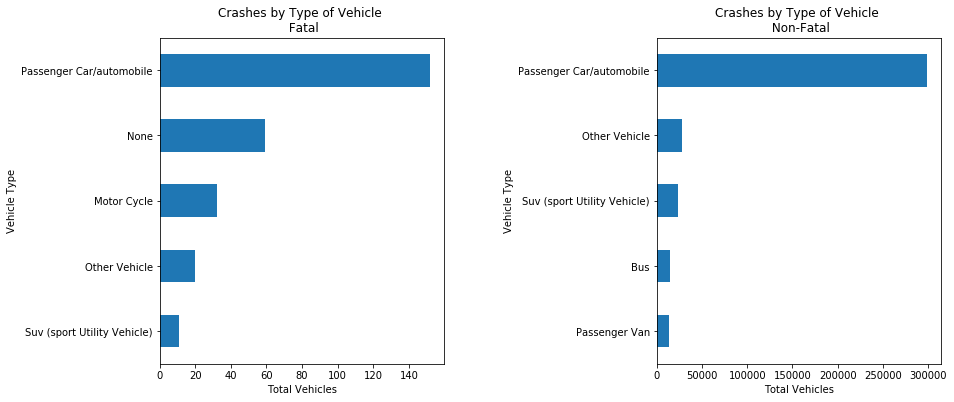

In [22]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
crash_data_fatal['INVEHICLETYPE'].value_counts(ascending = True).tail().plot(kind='barh')
plt.xlabel('Total Vehicles')
plt.ylabel('Vehicle Type')
plt.title('Crashes by Type of Vehicle \n Fatal')

plt.subplot(1,2,2)
crash_data_non_fatal['INVEHICLETYPE'].value_counts(ascending = True).tail().plot(kind='barh')
plt.xlabel('Total Vehicles')
plt.ylabel('Vehicle Type')
plt.title('Crashes by Type of Vehicle \n Non-Fatal')

plt.subplots_adjust(wspace=0.75)
plt.show()

The graph above shows that passenger cars/automobiles is the type of vehicle that is overwhelmingly involved in crashes. The biggest difference is that for fatal crashes, there is a much higher percentage of people who are not in a vehicle or on a motorcycle. This makes sense as those types of vehicles have a lot less protection.

In [38]:
def pie_plotter(metric):
    explode = (0.0, 0.7)
    
    labels = ['No', 'Yes']

    plt.figure(figsize = (8,6))
    crash_data[metric].value_counts().plot(kind='pie', labels = labels, explode = explode, autopct = '%0.3f%%', textprops={'fontsize': 18})
    plt.ylabel('')
    plt.title('Pie Chart Showing Proportion of ' + metric + ' Crashes', fontsize = 22)
    plt.show()

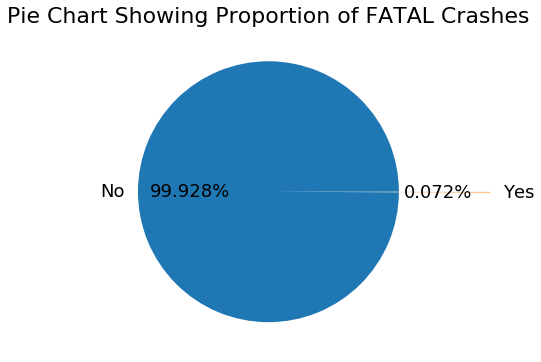

In [39]:
pie_plotter('FATAL')

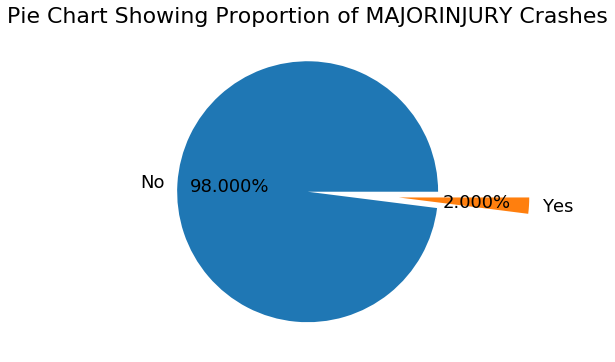

In [40]:
pie_plotter('MAJORINJURY')

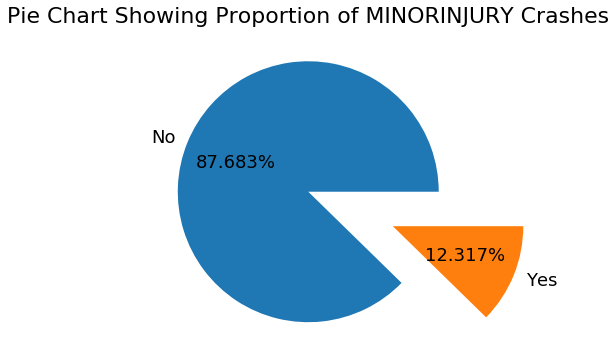

In [41]:
pie_plotter('MINORINJURY')

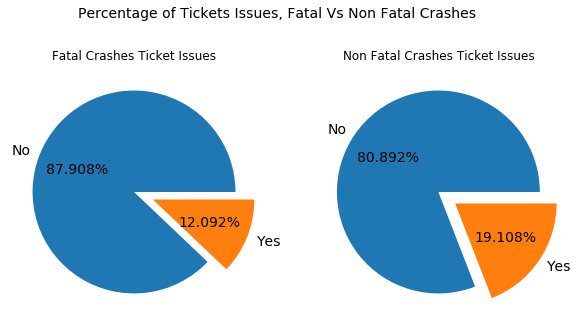

In [27]:
explode = (0.0, 0.2)
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,10))

labels = ['No', 'Yes']
values = crash_data_fatal['TICKETISSUED'].value_counts()
ax1.pie(values, labels = labels, explode = explode, autopct = '%0.3f%%', textprops={'fontsize': 14})
ax1.set_title('Fatal Crashes Ticket Issues')

values = crash_data_non_fatal['TICKETISSUED'].value_counts()
ax2.pie(values, labels = labels, explode = explode, autopct = '%0.3f%%', textprops={'fontsize': 14})
ax2.set_title('Non Fatal Crashes Ticket Issues')

plt.suptitle('Percentage of Tickets Issues, Fatal Vs Non Fatal Crashes', y = 0.76, fontsize = 14)
plt.show()

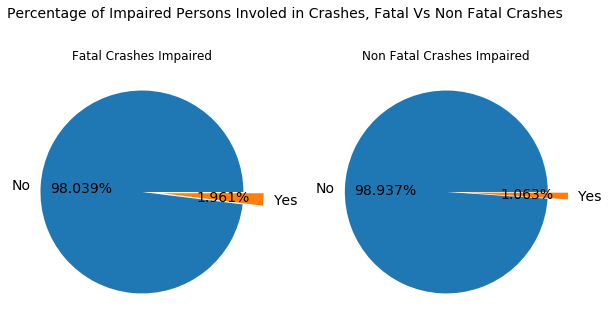

In [28]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,10))

labels = ['No', 'Yes']
values = crash_data_fatal['IMPAIRED'].value_counts()
ax1.pie(values, labels = labels, explode = explode, autopct = '%0.3f%%', textprops={'fontsize': 14})
ax1.set_title('Fatal Crashes Impaired')

values = crash_data_non_fatal['IMPAIRED'].value_counts()
ax2.pie(values, labels = labels, explode = explode, autopct = '%0.3f%%', textprops={'fontsize': 14})
ax2.set_title('Non Fatal Crashes Impaired')

plt.suptitle('Percentage of Impaired Persons Involed in Crashes, Fatal Vs Non Fatal Crashes', y = 0.76, fontsize = 14)
plt.show()

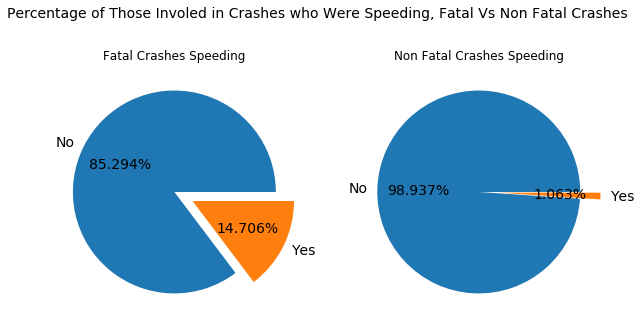

In [29]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,10))

labels = ['No', 'Yes']
values = crash_data_fatal['SPEEDING'].value_counts()
ax1.pie(values, labels = labels, explode = explode, autopct = '%0.3f%%', textprops={'fontsize': 14})
ax1.set_title('Fatal Crashes Speeding')

values = crash_data_non_fatal['IMPAIRED'].value_counts()
ax2.pie(values, labels = labels, explode = explode, autopct = '%0.3f%%', textprops={'fontsize': 14})
ax2.set_title('Non Fatal Crashes Speeding')

plt.suptitle('Percentage of Those Involed in Crashes who Were Speeding, Fatal Vs Non Fatal Crashes', y = 0.76, fontsize = 14)
plt.show()

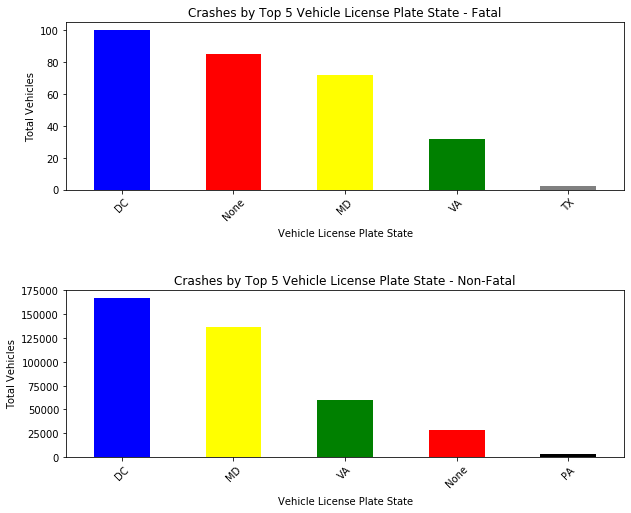

In [30]:
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
crash_data_fatal['LICENSEPLATESTATE'].value_counts(ascending = False)[:5].plot(
    kind='bar', color = ['blue', 'red', 'yellow', 'green', 'grey'])
plt.xlabel('Vehicle License Plate State')
plt.ylabel('Total Vehicles')
plt.title('Crashes by Top 5 Vehicle License Plate State - Fatal')
plt.xticks(rotation = 45)

plt.subplot(2,1,2)
crash_data_non_fatal['LICENSEPLATESTATE'].value_counts(ascending = False)[:5].plot(
    kind='bar', color = ['blue', 'yellow', 'green', 'red', 'black'])
plt.xlabel('Vehicle License Plate State')
plt.ylabel('Total Vehicles')
plt.title('Crashes by Top 5 Vehicle License Plate State - Non-Fatal')
plt.xticks(rotation = 45)

plt.subplots_adjust(hspace=0.6)
plt.show()

The graph above shows how for fatal crashes, the majority of crashes involves vehicles from the DMV are or unplated vehicles. For non-fatal crashes, the overall compisition of the origin of the vechicles is almost the same; there is a huge difference in that there is a much higher percentage of drives without plates who get involved in fatal crashes. This is probably due to the fact that unplated cars tend to be involved in illegal activity and are also more likely to be speeding and/or driving recklessly.

### Hyperparameter Tuning / Model Selection

This section will look at the preprocessing for the Hyperparameter Tuning / Model Selection, the actual Hyperparameter and then the Model Selection based on a number of different models. The best predictors will then be identified to determine whether a not a crash will be fatal.

In [42]:
# Remove the identifiers which are not relevant for the model
crash_data = crash_data.drop(columns = ['CRIMEID', 'OBJECTID', 'PERSONID', 'VEHICLEID'])

In [43]:
# Set the yes/no in the target variables to 1s and 0s
crash_data.FATAL = crash_data.FATAL.map(dict(Y=1, N = 0))

In [44]:
# Setting Target
target = 'FATAL'

In [45]:
# Divide the data into training (80%) and test (20%)
df_train, df_test = train_test_split(crash_data, train_size=0.8)

In [46]:
# Drop the target variable in the testing set
df_test = df_test.drop(columns = 'FATAL')

In [47]:
# Divide the training data into training (80%) and validation (20%)
df_train, df_valid = train_test_split(df_train, train_size=0.8, random_state=42, stratify=df_train[target])

In [48]:
df_train.head()

,PERSONTYPE,AGE,FATAL,MAJORINJURY,MINORINJURY,INVEHICLETYPE,TICKETISSUED,LICENSEPLATESTATE,IMPAIRED,SPEEDING
19097,Driver,32.0,0,N,N,Passenger Car/automobile,N,TX,N,N
539001,Driver,32.0,0,N,N,Passenger Van,Y,PA,N,N
371351,Driver,53.0,0,N,N,Other Vehicle,N,DC,N,N
89289,Driver,27.0,0,N,N,Passenger Car/automobile,Y,VA,N,N
73452,Driver,25.0,0,N,N,Passenger Car/automobile,Y,MD,N,N


In [49]:
df_valid.head()

,PERSONTYPE,AGE,FATAL,MAJORINJURY,MINORINJURY,INVEHICLETYPE,TICKETISSUED,LICENSEPLATESTATE,IMPAIRED,SPEEDING
119115,Passenger,44.0,0,N,N,Passenger Car/automobile,N,VA,N,N
275135,Driver,39.0,0,Y,N,Other Vehicle,N,None,N,N
445113,Driver,52.0,0,N,N,Passenger Car/automobile,Y,DC,N,N
417629,Driver,22.0,0,N,N,Passenger Car/automobile,N,None,N,N
559268,Driver,25.0,0,N,N,Passenger Car/automobile,Y,MD,N,N


In [50]:
df_test.head()

,PERSONTYPE,AGE,MAJORINJURY,MINORINJURY,INVEHICLETYPE,TICKETISSUED,LICENSEPLATESTATE,IMPAIRED,SPEEDING
483997,Pedestrian,17.0,N,Y,None,N,None,N,N
152810,Driver,47.0,N,N,Suv (sport Utility Vehicle),N,DC,N,N
99605,Driver,28.0,N,N,Other Vehicle,Y,DC,N,N
385341,Driver,21.0,N,N,Passenger Car/automobile,N,MD,N,N
488752,Passenger,59.0,N,N,Pickup Truck,N,DC,N,N


In [51]:
# Size of Training Set
print('Training Set')
print('Number of Rows: ', df_train.shape[0])
print('Number of Columns: ', df_train.shape[1])

Training Set
Number of Rows:  273116
Number of Columns:  10


In [52]:
# Size of Validation Set
print('Validation')
print('Number of Rows: ', df_valid.shape[0])
print('Number of Columns: ', df_valid.shape[1])

Validation
Number of Rows:  68279
Number of Columns:  10


In [53]:
# Size of Testing Set
print('Testing Set')
print('Number of Rows: ', df_test.shape[0])
print('Number of Columns: ', df_test.shape[1])

Testing Set
Number of Rows:  85349
Number of Columns:  9


In [54]:
# Combine df_train, df_valid and df_test
df = pd.concat([df_train, df_valid, df_test], sort=False)

In [55]:
def cat_var_checker(df):   
    # Get the dataframe of categorical variables and their number of unique value
    df_cat = pd.DataFrame([[var, df[var].nunique(dropna=False)]
                           for var in df.columns if df[var].dtype == 'object'],
                          columns=['var', 'nunique'])
    
    # Sort df_cat in accending order of the number of unique value
    df_cat = df_cat.sort_values(by='nunique', ascending=False).reset_index(drop=True)
    
    return df_cat

In [56]:
# Call cat_var_checker on df
df_cat = cat_var_checker(df)

# Print the dataframe
df_cat

,var,nunique
0,LICENSEPLATESTATE,59
1,INVEHICLETYPE,22
2,PERSONTYPE,4
3,MAJORINJURY,2
4,MINORINJURY,2
5,TICKETISSUED,2
6,IMPAIRED,2
7,SPEEDING,2


In [57]:
# One-hot-encode the categorical features in the combined data
df = pd.get_dummies(df, columns=np.setdiff1d(np.intersect1d(df.columns, df_cat['var']), [target]))

# Print the first 5 rows of df
df.head()

,AGE,FATAL,IMPAIRED_N,IMPAIRED_Y,INVEHICLETYPE_Aircraft,INVEHICLETYPE_Atv (all Terrain Vehicle),INVEHICLETYPE_Bus,INVEHICLETYPE_Cargo Van,INVEHICLETYPE_Construction/industrial Equipment,INVEHICLETYPE_Drugs/ Narcotics,...,MINORINJURY_N,MINORINJURY_Y,PERSONTYPE_Bicyclist,PERSONTYPE_Driver,PERSONTYPE_Passenger,PERSONTYPE_Pedestrian,SPEEDING_N,SPEEDING_Y,TICKETISSUED_N,TICKETISSUED_Y
19097,32.0,0.0,1,0,0,0,0,0,0,0,...,1,0,0,1,0,0,1,0,1,0
539001,32.0,0.0,1,0,0,0,0,0,0,0,...,1,0,0,1,0,0,1,0,0,1
371351,53.0,0.0,1,0,0,0,0,0,0,0,...,1,0,0,1,0,0,1,0,1,0
89289,27.0,0.0,1,0,0,0,0,0,0,0,...,1,0,0,1,0,0,1,0,0,1
73452,25.0,0.0,1,0,0,0,0,0,0,0,...,1,0,0,1,0,0,1,0,0,1


In [58]:
from sklearn.preprocessing import LabelEncoder

# The LabelEncoder
le = LabelEncoder()

# Encode the categorical target in the combined data
df[target] = le.fit_transform(df[target].astype(str))

# Print the first 5 rows of df
df.head()

,AGE,FATAL,IMPAIRED_N,IMPAIRED_Y,INVEHICLETYPE_Aircraft,INVEHICLETYPE_Atv (all Terrain Vehicle),INVEHICLETYPE_Bus,INVEHICLETYPE_Cargo Van,INVEHICLETYPE_Construction/industrial Equipment,INVEHICLETYPE_Drugs/ Narcotics,...,MINORINJURY_N,MINORINJURY_Y,PERSONTYPE_Bicyclist,PERSONTYPE_Driver,PERSONTYPE_Passenger,PERSONTYPE_Pedestrian,SPEEDING_N,SPEEDING_Y,TICKETISSUED_N,TICKETISSUED_Y
19097,32.0,0,1,0,0,0,0,0,0,0,...,1,0,0,1,0,0,1,0,1,0
539001,32.0,0,1,0,0,0,0,0,0,0,...,1,0,0,1,0,0,1,0,0,1
371351,53.0,0,1,0,0,0,0,0,0,0,...,1,0,0,1,0,0,1,0,1,0
89289,27.0,0,1,0,0,0,0,0,0,0,...,1,0,0,1,0,0,1,0,0,1
73452,25.0,0,1,0,0,0,0,0,0,0,...,1,0,0,1,0,0,1,0,0,1


In [59]:
# Separating the training data
df_train = df.iloc[:df_train.shape[0], :].copy(deep=True)

# Separating the validation data
df_valid = df.iloc[df_train.shape[0]:df_train.shape[0] + df_valid.shape[0], :].copy(deep=True)

# Separating the testing data
df_test = df.iloc[df_train.shape[0] + df_valid.shape[0]:, :].copy(deep=True)

In [60]:
features = np.setdiff1d(df.columns, [target])

In [61]:
# Get the feature matrix
X_train = df_train[features].to_numpy()
X_valid = df_valid[features].to_numpy()
X_test = df_test[features].to_numpy()

# Get the target vector
y_train = df_train[target].astype(int).to_numpy()
y_valid = df_valid[target].astype(int).to_numpy()

In [62]:
from sklearn.preprocessing import StandardScaler

# The StandardScaler
ss = StandardScaler()

# Standardize the training data
X_train = ss.fit_transform(X_train)

# Standardize the validation data
X_valid = ss.transform(X_valid)

# Standardize the testing data
X_test = ss.transform(X_test)

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.neural_network import MLPClassifier

models = {'lr': LogisticRegression(class_weight='balanced', random_state=42),
          'dtc': DecisionTreeClassifier(class_weight='balanced', random_state=42),
          'rfc': RandomForestClassifier(class_weight='balanced', random_state=42),
          'hgbc': HistGradientBoostingClassifier(random_state=42),
          'xgbc': XGBClassifier(seed=42),
          'mlpc': MLPClassifier(early_stopping=True, random_state=42)}

In [64]:
from sklearn.pipeline import Pipeline

pipes = {}

for acronym, model in models.items():
    pipes[acronym] = Pipeline([('model', model)])

In [65]:
from sklearn.model_selection import PredefinedSplit

# Combine the feature matrix in the training and validation data
X_train_valid = np.vstack((X_train, X_valid))

# Combine the target vector in the training and validation data
y_train_valid = np.append(y_train, y_valid)

# Get the indices of training and validation data
train_valid_idxs = np.append(np.full(X_train.shape[0], -1), np.full(X_valid.shape[0], 0))

# The PredefinedSplit
ps = PredefinedSplit(train_valid_idxs)

In [66]:
param_grids = {}

In [67]:
# The grids for C
C_grids = [10 ** i for i in range(-2, 3)]

# The grids for tol
tol_grids = [10 ** i for i in range(-6, -1)]

# Update param_grids
param_grids['lr'] = [{'model__C': C_grids,
                      'model__tol': tol_grids}]

In [68]:
# The grids for min_samples_split
min_samples_split_grids = [2, 30, 100]

# The grids for min_samples_leaf
min_samples_leaf_grids = [1, 30, 100]

# The grids for max_depth
max_depth_grids = range(1, 11)

# Update param_grids
param_grids['dtc'] = [{'model__min_samples_split': min_samples_split_grids,
                       'model__min_samples_leaf': min_samples_leaf_grids,
                       'model__max_depth': max_depth_grids}]

In [69]:
# The grids for min_samples_split
min_samples_split_grids = [2, 20, 100]

# The grids for min_samples_leaf
min_samples_leaf_grids = [1, 20, 100]

# Update param_grids
param_grids['rfc'] = [{'model__min_samples_split': min_samples_split_grids,
                       'model__min_samples_leaf': min_samples_leaf_grids}]

In [70]:
# The grids for learning_rate
learning_rate_grids = [10 ** i for i in range(-3, 2)]

# The grids for min_samples_leaf
min_samples_leaf_grids = [1, 20, 100]

# Update param_grids
param_grids['hgbc'] = [{'model__learning_rate': learning_rate_grids,
                        'model__min_samples_leaf': min_samples_leaf_grids}]

In [71]:
# The grids for eta
eta_grids = [10 ** i for i in range(-4, 1)]

# The grids for gamma
gamma_grids = [0, 10, 100]

# The grids for lambda
lambda_grids = [10 ** i for i in range(-4, 5)]

# Update param_grids
param_grids['xgbc'] = [{'model__eta': eta_grids,
                        'model__gamma': gamma_grids,
                        'model__lambda': lambda_grids}]

In [72]:
# The grids for alpha
alpha_grids = [10 ** i for i in range(-6, -1)]

# The grids for learning_rate_init
learning_rate_init_grids = [10 ** i for i in range(-5, 0)]

# Update param_grids
param_grids['mlpc'] = [{'model__alpha': alpha_grids,
                        'model__learning_rate_init': learning_rate_init_grids}]

In [73]:
from sklearn.model_selection import GridSearchCV

# The list of [best_score_, best_params_, best_estimator_] obtained by GridSearchCV
best_score_param_estimator_gs = []

for acronym in pipes.keys():
    # GridSearchCV
    gs = GridSearchCV(estimator=pipes[acronym],
                      param_grid=param_grids[acronym],
                      scoring='f1_micro',
                      n_jobs=-1,
                      cv=ps,
                      return_train_score=True)
        
    # Fit the pipeline
    gs = gs.fit(X_train_valid, y_train_valid)
    
    # Update best_score_param_estimator_gs
    best_score_param_estimator_gs.append([gs.best_score_, gs.best_params_, gs.best_estimator_])
    
    # Sort cv_results in ascending order of 'rank_test_score' and 'std_test_score'
    cv_results = pd.DataFrame.from_dict(gs.cv_results_).sort_values(by=['rank_test_score', 'std_test_score'])
    
    # Get the important columns in cv_results
    important_columns = ['rank_test_score',
                         'mean_test_score', 
                         'std_test_score', 
                         'mean_train_score', 
                         'std_train_score',
                         'mean_fit_time', 
                         'std_fit_time',                        
                         'mean_score_time', 
                         'std_score_time']
    
    # Move the important columns ahead
    cv_results = cv_results[important_columns + sorted(list(set(cv_results.columns) - set(important_columns)))]

C:\Users\12023\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:40:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [74]:
# Sort best_score_param_estimator_gs in descending order of the best_score_
best_score_param_estimator_gs = sorted(best_score_param_estimator_gs, key=lambda x : x[0], reverse=True)

# Print best_score_param_estimator_gs
pd.DataFrame(best_score_param_estimator_gs, columns=['best_score', 'best_param', 'best_estimator'])

,best_score,best_param,best_estimator
0,0.999297,"{'model__learning_rate': 0.001, 'model__min_sa...",(HistGradientBoostingClassifier(l2_regularizat...
1,0.999297,"{'model__eta': 0.0001, 'model__gamma': 0, 'mod...","(XGBClassifier(base_score=0.5, booster='gbtree..."
2,0.999297,"{'model__alpha': 1e-06, 'model__learning_rate_...","(MLPClassifier(activation='relu', alpha=1e-06,..."
3,0.988137,"{'model__max_depth': 4, 'model__min_samples_le...","(DecisionTreeClassifier(ccp_alpha=0.0, class_w..."
4,0.955448,"{'model__min_samples_leaf': 20, 'model__min_sa...","((DecisionTreeClassifier(ccp_alpha=0.0, class_..."
5,0.838647,"{'model__C': 0.01, 'model__tol': 1e-06}","(LogisticRegression(C=0.01, class_weight='bala..."


For the HistGradientBoostingClassifier and MLPClassier models, I got the error which states 'object has no attribute 'feature_importances_''. Since the score for the XGBClassifier was the same with 0.999297, it was chosen to look at the importanes of different features. To get a bigger range, I also chose the DecisionTreeClassifier, which have a score very close to the other three. The models with the highest important features will be chosen.

In [92]:
# Get the best_score, best_param and best_estimator of random forest obtained by GridSearchCV
best_score_rfc, best_param_rfc, best_estimator_rfc = best_score_param_estimator_gs[1]

# Get the dataframe of feature and importance
df_fi_rfc = pd.DataFrame(np.hstack((features.reshape(-1, 1), best_estimator_rfc.named_steps['model'].feature_importances_.reshape(-1, 1))),
                         columns=['Features', 'Importance'])

# Sort df_fi_rfc in descending order of the importance
df_fi_rfc = df_fi_rfc.sort_values(ascending=False, by='Importance').reset_index(drop=True)

# Print the first 5 rows of df_fi_rfc
df_fi_rfc.head()

,Features,Importance
0,INVEHICLETYPE_Motor Cycle,0.195212
1,MAJORINJURY_N,0.181538
2,LICENSEPLATESTATE_TX,0.149698
3,SPEEDING_N,0.103561
4,TICKETISSUED_N,0.06694


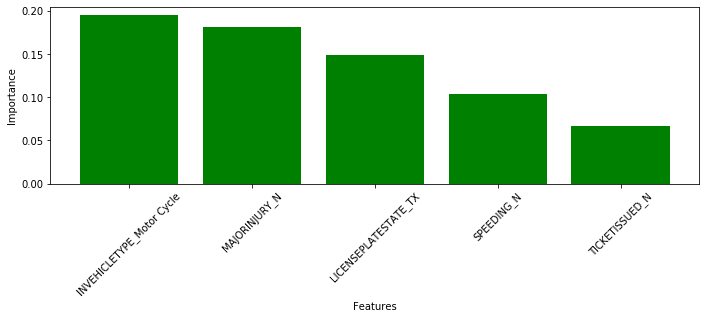

In [82]:
# Create a figure
fig = plt.figure(figsize=(10, 5))

# Implement me
# The bar plot of the top 5 feature importance
plt.bar(df_fi_rfc['Features'][:5], df_fi_rfc['Importance'][:5], color='green')

# Set x-axis
plt.xlabel('Features')
plt.xticks(rotation=90)

# Set y-axis
plt.ylabel('Importance')

# Save and show the figure
plt.tight_layout()
plt.xticks(rotation = 45)
plt.title('Importance for XGB Classifier')
plt.show()

In [81]:
# Get the best_score, best_param and best_estimator of random forest obtained by GridSearchCV
best_score_rfc_2, best_param_rfc_2, best_estimator_rfc_2 = best_score_param_estimator_gs[3]

# Get the dataframe of feature and importance
df_fi_rfc_2 = pd.DataFrame(np.hstack((features.reshape(-1, 1), best_estimator_rfc_2.named_steps['model'].feature_importances_.reshape(-1, 1))),
                         columns=['Features', 'Importance'])

# Sort df_fi_rfc in descending order of the importance
df_fi_rfc_2 = df_fi_rfc_2.sort_values(ascending=False, by='Importance').reset_index(drop=True)

# Print the first 5 rows of df_fi_rfc
df_fi_rfc_2.head()

,Features,Importance
0,INVEHICLETYPE_None,0.306189
1,SPEEDING_Y,0.267072
2,INVEHICLETYPE_Motor Cycle,0.155513
3,MINORINJURY_N,0.132
4,MINORINJURY_Y,0.117607


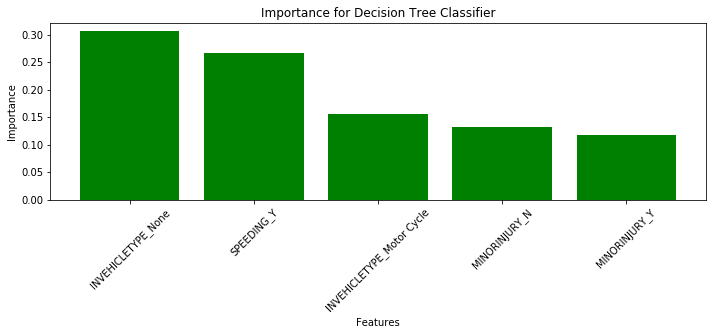

In [84]:
# Create a figure
fig = plt.figure(figsize=(10, 5))

# Implement me
# The bar plot of the top 5 feature importance
plt.bar(df_fi_rfc_2['Features'][:5], df_fi_rfc_2['Importance'][:5], color='green')

# Set x-axis
plt.xlabel('Features')
plt.xticks(rotation=90)

# Set y-axis
plt.ylabel('Importance')

# Save and show the figure
plt.tight_layout()
plt.xticks(rotation = 45)
plt.title('Importance for Decision Tree Classifier')
plt.show()

With the two combined models, the features with the highest importance in determining whether a crash will be fatal or not are as follows:
 - Vehicle Type of None (0.306189)
 - Speeding (0.267072)
 - Vehicle Type of Motorcycle (0.155513)

## Discussion

Based on the findings based on the EDA and the different models, a number of conclusions can be drawn. One of the biggest problems leading to fatal crashes is the fact that the vehicle involved was speeding. This was shown by the Decision Tree Classifier which gave it an importance of 0.267072. Additionally, when looking at the EDA, there was a percentage increase from 1.1% of cars speeding involved in non-fatal crashes to 14.7% of cars speeding which were involved in fatal crashes. This statistic is supported by the fact that the MPD decided to reduce the speed limit from 25 MPH to 20 MPH as the default speed limit on June 1st, 2020. DC also has a no-chase policy, which would help reduce the number of crashes due to speeding during a car chase; which would also result in reckless driving. This no-chase policy also aims to reduce the number of unplated vehicles as there is no fear of being chased; from the EDA, it is clear that unplated vehicles are involved in a much higher proportion in fatal crashes than non-fatal crashes.

The importance of this policy is emphasized by the fact that according to WUSA9.com on October 29, 2020 DC police violated this no chase policy which resultant in the driver of the getaway vehicle losing his life from crashing his moped into another vehicle. The article can be accessed at: https://www.wusa9.com/article/news/local/dc/dc-police-chase-policies-karon-hylton-moped-death/65-1e7f17ea-6b2f-4fa6-a3c0-fab44b70e539. 

This policy can also be tied to the fact that bystander are more likely to be hit by reckless drivers due to car chases. The Decision Tree Classifier gave the vehicle type of none the highest importance when it comes to predicting fatal crashes. According to an article by Gilman & Bedigian, "in 2010, Washington D.C. led the country with the highest percentage of pedestrians killed in traffic accidents. Between 2011 and 2013 there was actually an increase in pedestrian injuries in Washington D.C, from about 831 in 2011 to more than 1,000 in 2013. In 2013, at least 12 of those accidents were fatal, and 74 were disabling injuries. In the broader DC Metro area, there were 60 pedestrian fatalities in 2015, up from 53 in 2014, and 45 in 2013. The number of pedestrians killed in car accidents has changed little over the past decade. However, while cars are getting safer, with greater protection for passenger and drivers, pedestrians are still unprotected in the face of a car accident. Pedestrians do not have the benefit of crumple zones, air bags, or seat belts. When a car hits a pedestrian, the pedestrian always loses." This article can be accessed at: https://www.gilmanbedigian.com/pedestrians-hit-by-cars-in-dc/

To combat this, the MPD offers the following advice to pedestrians:
 - Use signaled crosswalks when possible. 
 - Use extreme caution when crossing at intersections without signals.
 - Look both ways before crossing the street.
 - Never run between cars into the street.
 - Wear clothing that allows drivers and people to see you.
 
 This, along with other tips can be accessed at: https://mpdc.dc.gov/page/share-road-tips-drivers-cyclists-and-pedestrians
 
Similar to pedestrians, motorcyclists do not have the benefit of crumple zones, air bags, or seat belts, and when hit by a car, the motorcyclist always loses. The XGB classifier gave motorcyclists the highest importance of 0.195212, while the Decision Tree Classifier gave them an importance of 0.155513. Another explanation for such a high importance is that moped companies such as Revel offer DC residents to rent them for very cheap, which can be taken advantage of to be used as getaway vehicles for different crimes. In Washington DC, it is law for motorcycle riders to wear a DOT approved helmet and companies such as revel ban riders for not complying with the law. 